In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/processed/tmax2m_sp_point.csv", parse_dates=["date"])
data = data.set_index("date")


In [3]:
data['tmax2m'] = data['tmax2m'] + 1.3  # Bias correction

In [4]:
data['year'] = data.index.year
threshold_temperature = 34.7 + 1.3  # Adjusted threshold with bias correction

data['cond_temp'] = (data['tmax2m'] > threshold_temperature).astype(int)

def _mark_runs(series, min_len=3):
    cond = series.astype(bool)
    runs = (cond != cond.shift()).cumsum()
    run_sizes = cond.groupby(runs).transform('size')
    return ((cond) & (run_sizes >= min_len)).astype(int)

data['event'] = _mark_runs(data['cond_temp'])

frequency_events_per_year = data['event'].sum() / data['year'].nunique()

print(f"Frecuencia de eventos por año: {frequency_events_per_year:.4f}")

Frecuencia de eventos por año: 0.7500


In [5]:
def plot_panels_time_series_temperature(data, list_years, threshold_temperature):

    width = 0.4
    height = 0.38   
    
    fig = plt.figure(figsize=(20, 10))

    axes = [plt.axes([0.05, 0.5, width, height]), # arriba a la izquierda
            plt.axes([0.55, 0.5, width, height]), # arriba a la derecha
            plt.axes([0.05, 0.05, width, height]), # abajo a la izquierda
            plt.axes([0.55, 0.05, width, height])  # abajo a la derecha
            ]
    
    for i, iyear in enumerate(list_years):
        ax = axes[i]
        yearly_data = data[data.index.year == iyear]
        ax.plot(yearly_data.index, yearly_data['tmax2m'], label='ERA5 Tmax', color='darkgrey', zorder=1, alpha=0.8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(f'Year {iyear}', fontsize=12, loc='left')
        ax.set_xlabel('Date')
        ax.set_ylabel('Tmax (°C)')
        ax.set_ylim([10, 40])

        # Highlight heatwave events
        ax.axhline(y=threshold_temperature, color='orange', linestyle='--', label='Umbral de Ola de Calor', zorder=3)
        heatwave_days = yearly_data[yearly_data['event'] == 1]
        ax.scatter(heatwave_days.index, heatwave_days['tmax2m'], color='red', label='Heatwave Days', zorder=5, s=10)

        # <<< BLOQUE NUEVO AQUI >>>
        # Sombreado para cada día con evento
        for start, end in zip(heatwave_days.index, heatwave_days.index[1:]):
            if (end - start).days == 1:
                ax.axvspan(start, end, color='red', alpha=0.15, zorder=0)
            else:
                ax.axvspan(start, start + pd.Timedelta(days=1), color='red', alpha=0.15, zorder=0)

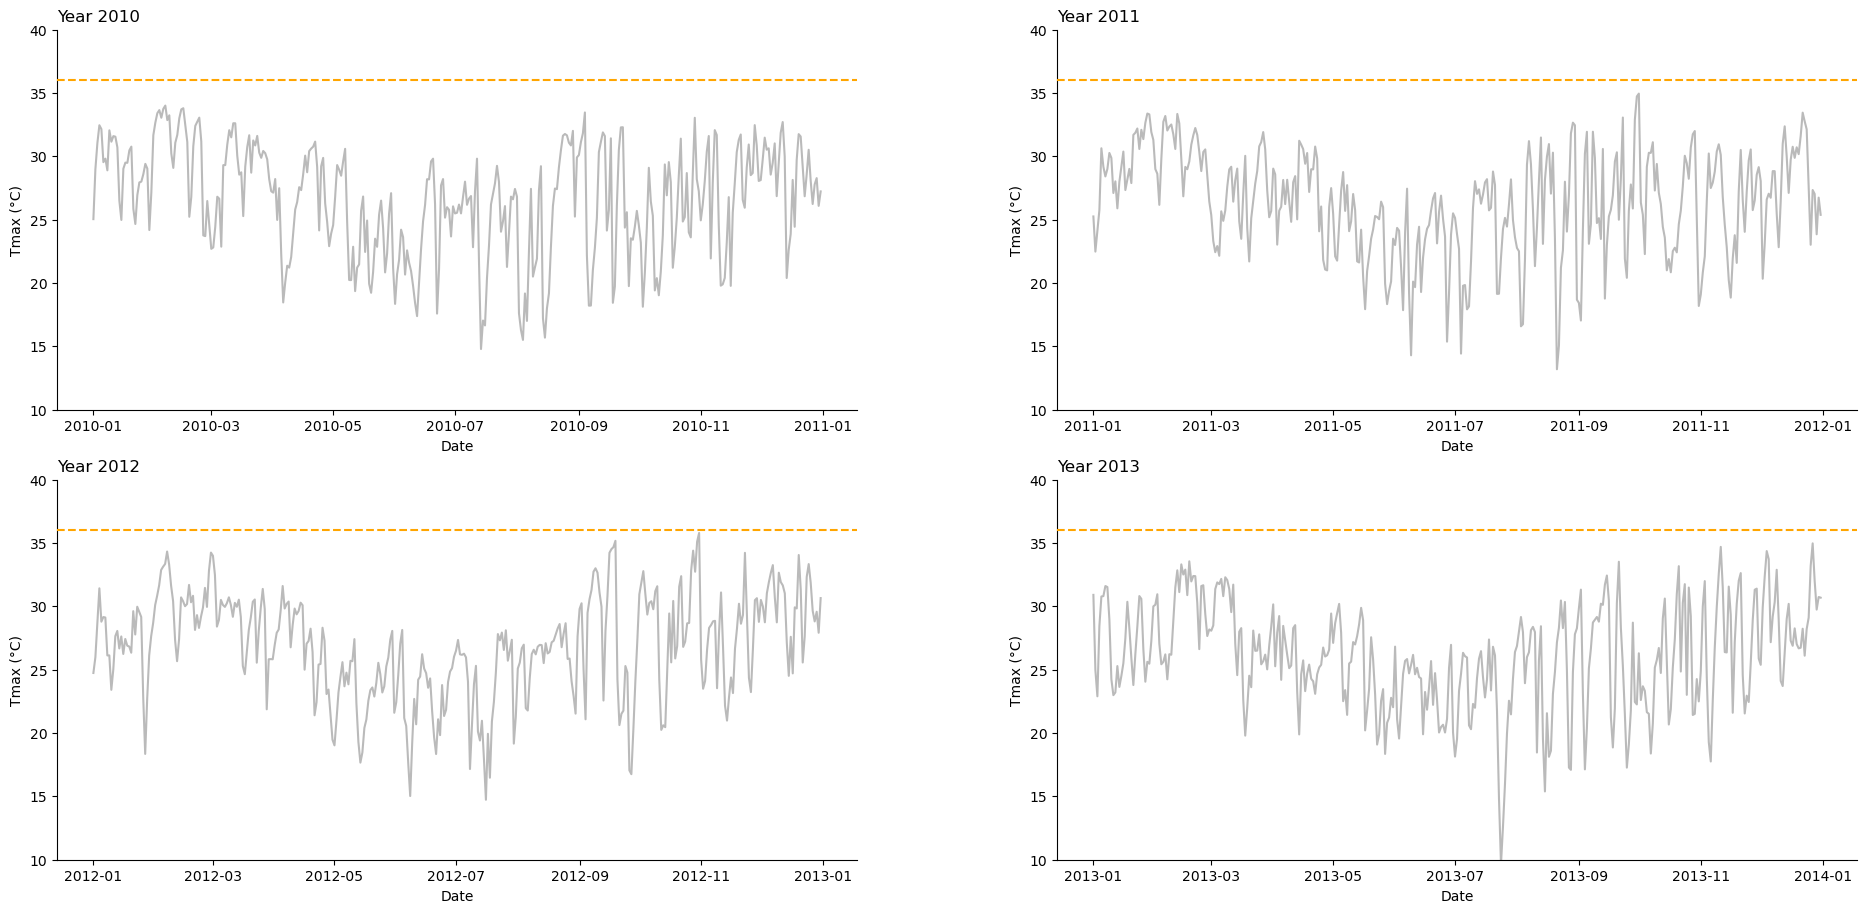

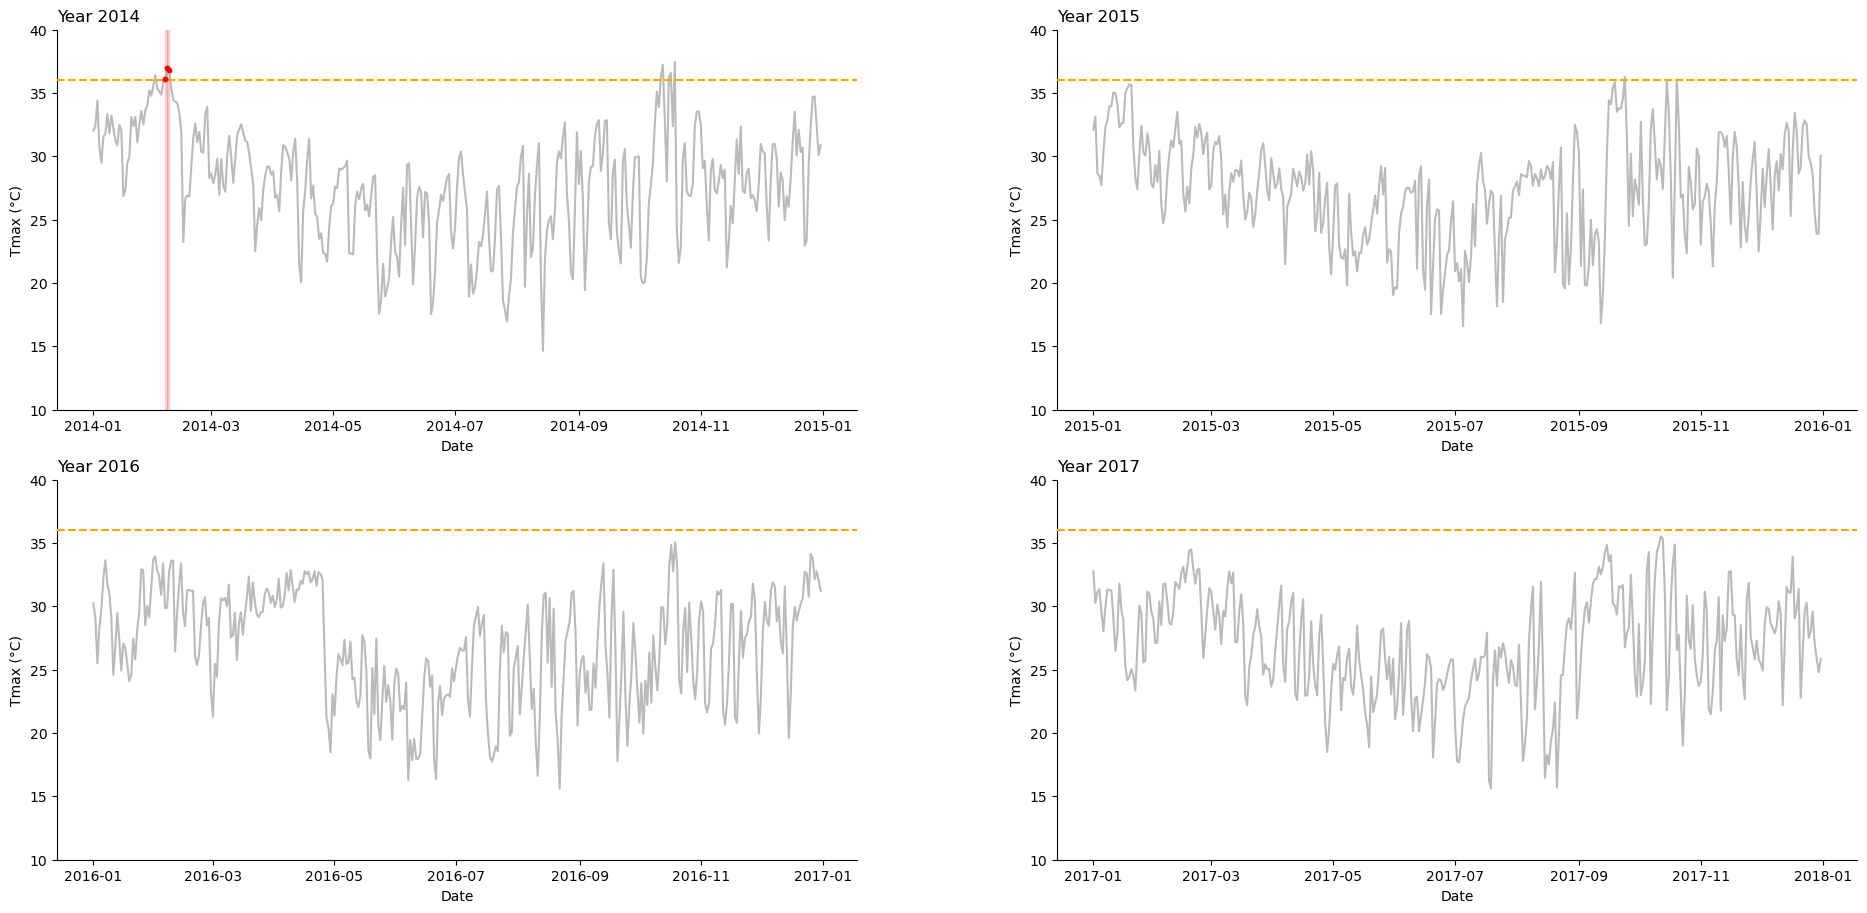

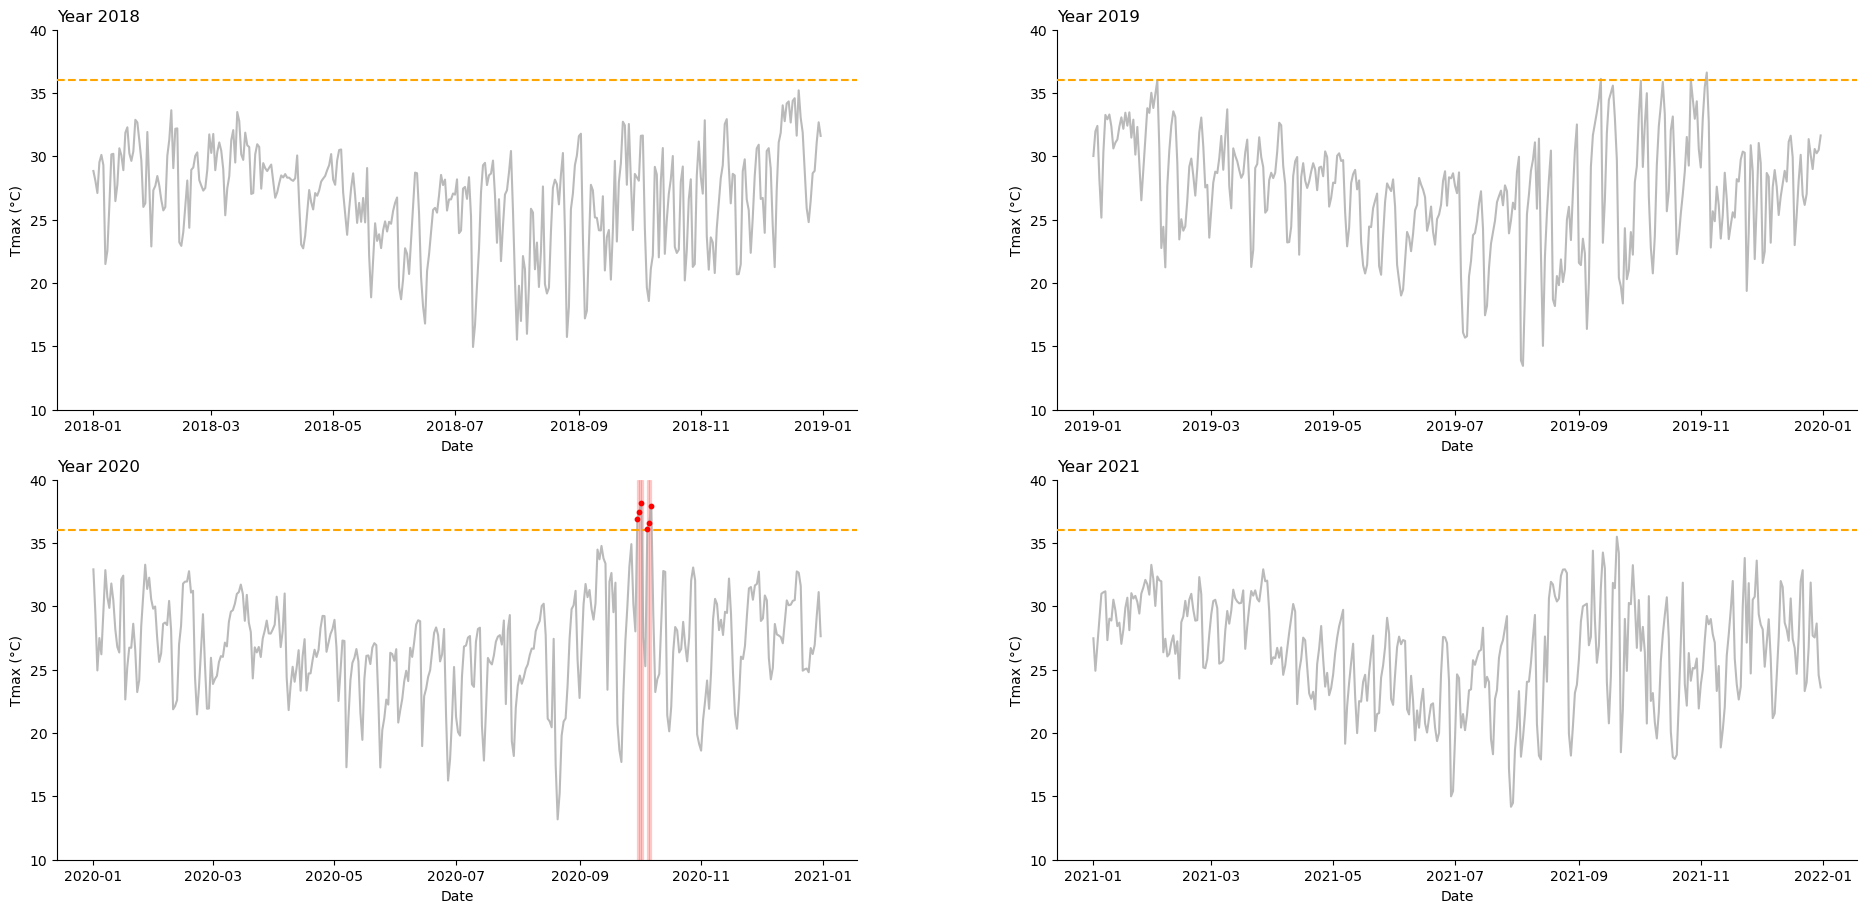

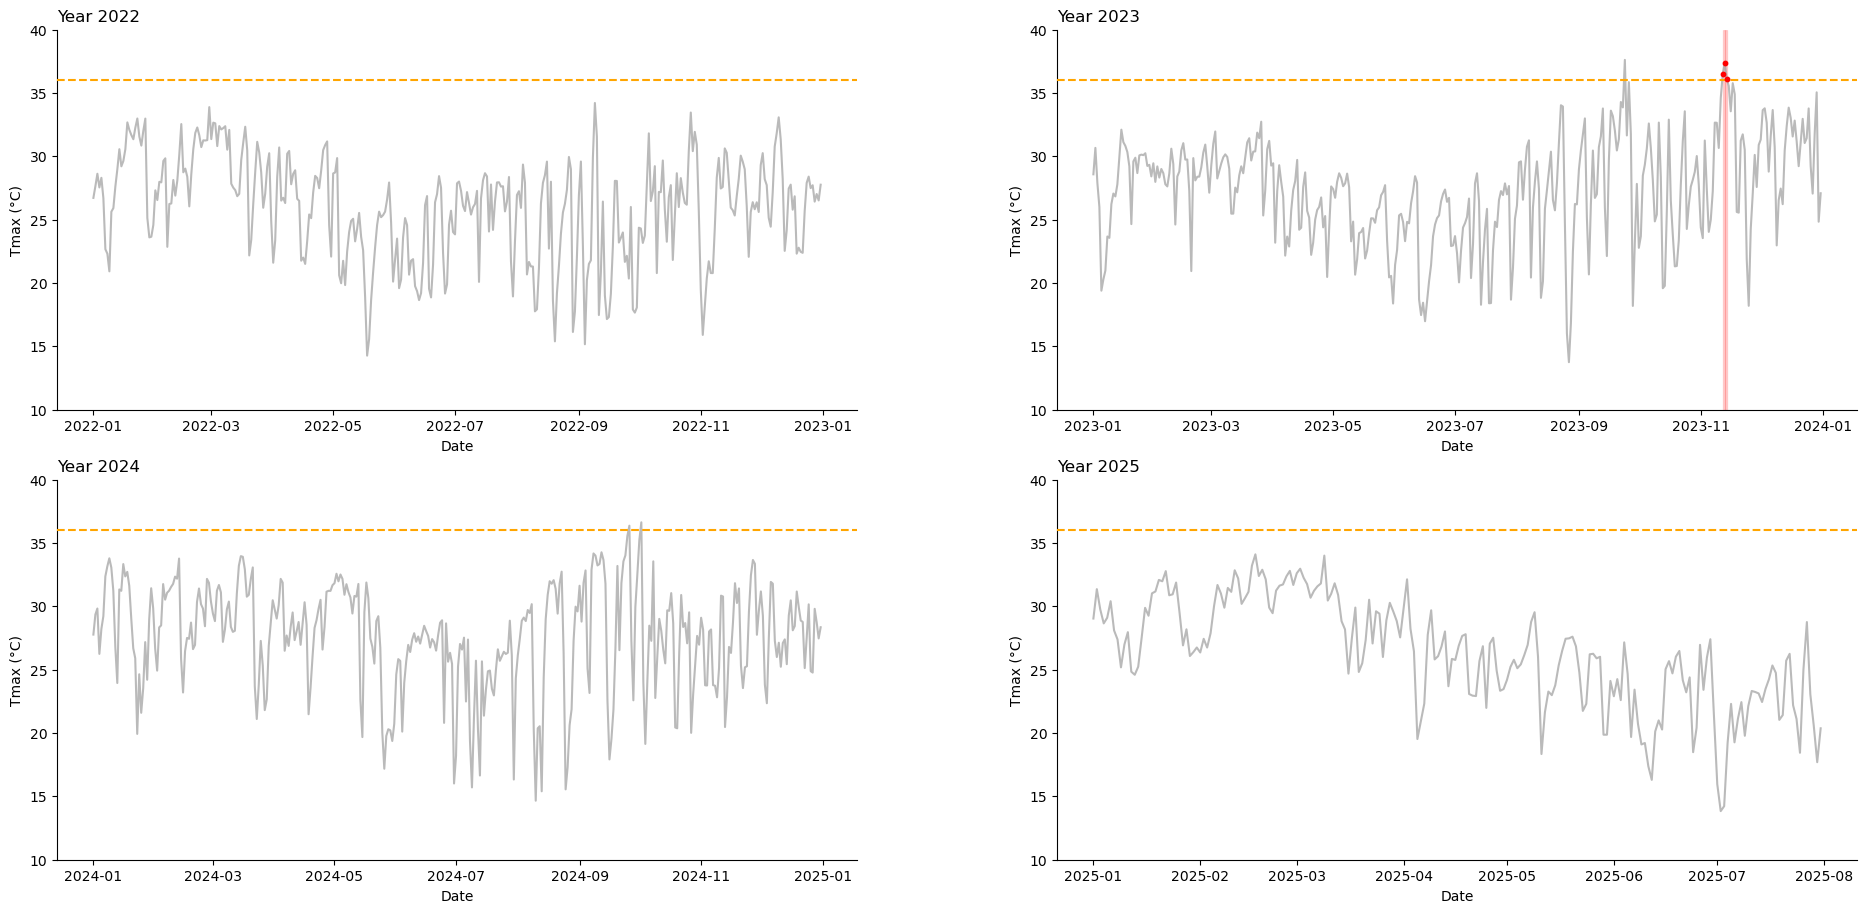

In [6]:
total_years = list(data.index.year.unique())

for year_chunk in [total_years[i:i + 4] for i in range(0, len(total_years), 4)]:
    plot_panels_time_series_temperature(data, year_chunk, threshold_temperature)
